# fitting monte carlo results to birth death rates from the full simulation
Tim Tyree<br>
3.30.2021

In [1]:
from lib.my_initialization import *
import random,scipy
from lib.measure.compute_slope import *
from lib.measure.compute_sliding_slope import *
from lib.measure.powerlaw import *
%load_ext autoreload
%autoreload 2

from scipy import stats
alpha=0.1

In [2]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A'] #[mHz?]/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A'] #[mHz?]/cm^2



In [5]:
#load osg data
data_mc_fn='osg_output/run_1_to_3_merged.csv'
# data_mc_fn='osg_output/run_6_all.csv'#run_1_to_3_merged.csv'
df=pd.read_csv(data_mc_fn)
df.drop(columns=['dt'],inplace=True)

#slice the data
# query=(df.set_second==0)&(df.reflect==0)&(df.r==0.1)&(df.Dt==0.001)&(df.Dt==0.001)&(df.D==1.0)&(df.L==5.)&(df.kappa==80)
# query=(df.set_second==0)&(df.reflect==0)&(df.Dt==0.01)#&(df.D==1.0)&(df.L==5.)&(df.kappa==80)&(df.r==0.1)
# query=(df.set_second==0)&(df.reflect==0)&(df.Dt==0.01)#&(df.D==1.0)&(df.L==5.)&(df.kappa==80)&(df.r==0.1)
# df=df[query].copy()
#extract column values
r_values=np.array(sorted(set(df.r.values)))#cm
D_values=np.array(sorted(set(df.D.values)))#cm^2/s
L_values=np.array(sorted(set(df.L.values)))#cm
A_values=L_values**2#cm^2
kappa_values=np.array(sorted(set(df.kappa.values)))#1/s

In [32]:
# df['Dt_over_dt']=df.Dt/1e-5
# Dt_over_dt_values=np.array(sorted(set(df.Dt_over_dt.values)))#1/s

# df['set_second']=0
# df.drop('set_second',inplace=True)
beep(3)
df.head()

,5,6,7,8,9,10,11,12,13,14,...,64,65,66,67,68,69,r,D,L,kappa
0,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,...,0.00007,0.00007,0.00007,0.00007,0.00007,0.00007,0.3,0.2,15.8114,1000
1,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,0.40660,...,0.00029,0.00029,0.00029,0.00029,0.00029,0.00029,0.3,0.2,15.8114,1000
2,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,5.15927,...,0.00979,0.00979,0.00979,0.00979,0.00979,0.00979,0.3,0.2,15.8114,1000
3,19.50541,13.01108,13.01108,13.01108,13.01108,0.47663,0.47663,0.47663,0.47663,0.47663,...,0.00329,0.00329,0.00329,0.00329,0.00329,0.00329,0.3,0.2,15.8114,1000
4,11.12850,5.89572,5.89572,5.89572,5.89572,1.87785,1.87785,0.07995,0.07995,0.07995,...,0.00028,0.00028,0.00028,0.00028,0.00028,0.00028,0.3,0.2,15.8114,1000


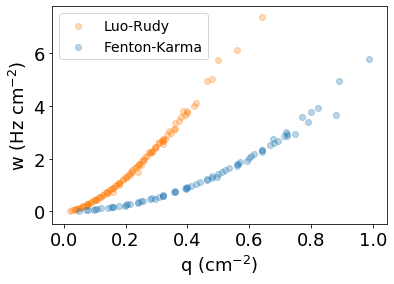

In [33]:
yscale=10**3
fontsize=18
#plot up WJ's results
plt.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,c='C1',label='Luo-Rudy')
plt.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,c='C0',label='Fenton-Karma')
# plt.ylim([1e-5,1e-2])
# plt.yscale('log')
# plt.xscale('log')
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-4)
plt.show()

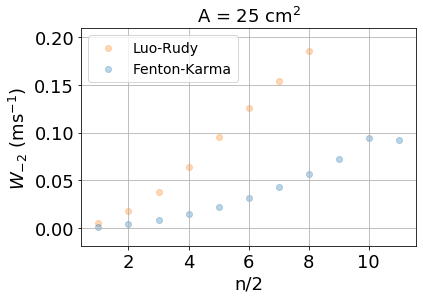

In [34]:
yscale=10**3
fontsize=18
#plot up WJ's results
querylr=lr.A==25
queryfk=fk.A==25
plt.scatter(x=lr[querylr].No2.values,y=lr[querylr].rate.values,alpha=0.3,c='C1',label='Luo-Rudy')
plt.scatter(x=fk[queryfk].No2.values,y=fk[queryfk].rate.values,alpha=0.3,c='C0',label='Fenton-Karma')
# plt.ylim([1e-5,1e-2])
# plt.yscale('log')
# plt.xscale('log')
plt.grid('on')
plt.title(r'A = 25 cm$^2$',fontsize=fontsize)
plt.xlabel(r'n/2',fontsize=fontsize)
plt.ylabel(r'$W_{-2}$ (ms$^{-1}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-4)
plt.show()

In [35]:
#compute w_lr and w_fk using a linear regression of a log-log plot
yscale=10**3
query=fk.q>0.2
x=fk[query].q.values
y=yscale*fk[query].w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_out

{'m': 1.9447060275370367,
 'Delta_m': 0.029617122208703113,
 'b': 1.7091950494051997,
 'Delta_b': 0.024489019143397704,
 'Rsquared': 0.9967057268076673}

In [36]:
#compute w_lr and w_fk using a linear regression of a log-log plot
yscale=10**3
query=lr.q>0.2
x=lr[query].q.values
y=yscale*lr[query].w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_out

{'m': 1.5439116497751577,
 'Delta_m': 0.03447523242468118,
 'b': 2.7539985812568752,
 'Delta_b': 0.041657775773998006,
 'Rsquared': 0.9935596891108925}

In [37]:
# df.head()

In [38]:
def GetPlotUnivCurve(r,D,kappa,ax,alpha=1.,fontsize=18):
    for L in L_values:
        #get slice
        query=(df.r==r)&(df.D==D)&(df.L==L)&(df.kappa==kappa)
        dff=df[query].copy().drop(columns=['r','D','L','kappa'])
        if dff.size>0:
            #compute x,y values
            A=L**2
            dfd=dff.describe().T.drop(columns=['count'])
            y_values=1/dfd['mean'].values.copy()/A
            dfd.reset_index(inplace=True,drop=True)
            dfd['N']=dfd.index.values+11
            x_values=dfd.N.values/A
            #plot x,y values
            ax.scatter(x_values,y_values,s=10,label=f'A={A:.2f}'+r' $(cm^{2})$',alpha=alpha)
    ax.set_xlabel(r'number density (cm$^{-2}$)', fontsize=fontsize)
    ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    ax.tick_params(axis='both', which='minor', labelsize=0)
    ax.legend(fontsize=fontsize-6,ncol=2)
#     ax.set_title(f'r={r} cm, D={D} '+r'cm$^{-2}/s$, $\kappa=$'+f'{kappa} Hz', fontsize=fontsize)
#     if not saving:
#         plt.show()
#     else:
#         plt.tight_layout()
#         os.chdir(savefig_folder)
#         plt.savefig(savefig_fn, dpi=300)
# #         print(f"saved figure in \n\t{savefig_fn}")
#         plt.close()
    return True

r=1.0, D=2.0, kappa=1000


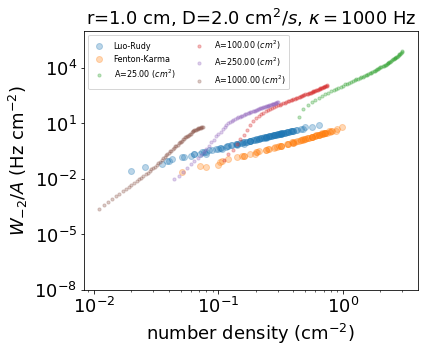

In [42]:
# i,j,k=2,0,2
# i,j,k=2,-1,-1
i,j,k=-5,-1,-1
# i,j,k=-5,0,2
#one test case
r=r_values[i];D=D_values[j];kappa=kappa_values[k];yscale=10**3
# r=0.2;D=2.;kappa=90
print(f'r={r}, D={D}, kappa={kappa}')
#plot the values
figsize=(6,5)
fontsize=18
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'model_comparison_r_{r}_D_{D}_k_{kappa}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#plot up results from full simulation
ax.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,label='Luo-Rudy')
ax.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,label='Fenton-Karma')
ax.set_title(f'r={r} cm, D={D} '+r'cm$^{2}/s$, $\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

#plot up results from simple monte carlo simulation
retval=GetPlotUnivCurve(r,D,kappa,ax,alpha=0.3)
ax.legend(loc='best',fontsize=fontsize-10,ncol=2)
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
plt.ylim([1e-8,1e+6])
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#         plt.close()

__Results__: 
- There apppears to be no dependence on A_{domain} for all parameters
- There apppears to be no dependence on D_{spiral tips} for some parameters

In [43]:
df.columns

Index(['5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17',
       '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29',
       '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41',
       '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65',
       '66', '67', '68', '69', 'r', 'D', 'L', 'kappa'],
      dtype='object')

In [60]:
def agg_over_A(r,D,kappa,Dt_over_dt=1.):
    '''aggregate x,y values over A'''
    xvl=[];yvl=[];
    for L in L_values:
        #get slice
        query=(df.r==r)&(df.D==D)&(df.L==L)&(df.kappa==kappa)#&(df.Dt_over_dt==Dt_over_dt)
#         dff=df[query].copy()#.drop(columns=['r','D','L','kappa'])
#         dff=df[query].copy().drop(columns=['set_second', 'reflect', 'r', 'niter', 'kappa', 'L', 'Dt', 'D',
#         'Dt_over_dt'])

        dff=df[query].copy().drop(columns=['r','D','L','kappa'])

        if dff.size>0:
            #compute x,y values
            A=L**2
#             dfd=dff.groupby('N').CollRate.mean()
#             dfd.drop('set_second',inplace=True)
#             x_values=dfd.values
#             y_values=dfd.index.values

            dfd=dff.mean()
            x_values=np.array([eval(iv) for iv in dfd.index.values])/A
            y_values=dfd.values.copy()**-1/A
            xvl.append(x_values)
            yvl.append(y_values)
    if len(xvl)==0:
        return None,None
    x_values=np.concatenate(xvl)
    y_values=np.concatenate(yvl)
    return x_values,y_values

#         dfd=dff.describe().T.drop(columns=['count'])
#         y_values=1/dfd['mean'].values.copy()/A
#         dfd.reset_index(inplace=True,drop=True)
#         dfd['N']=dfd.index.values+Nmin
#         x_values=dfd.N.values/A

In [61]:
def agg_over_D(r,kappa):
    '''aggregate over D'''
    xvl=[];yvl=[];
    for D in D_values:
        x_values,y_values=agg_over_A(r,D,kappa)
        if x_values is not None:
            xvl.append(x_values)
            yvl.append(y_values)
    if len(xvl)==0:
        return None,None
    x_values=np.concatenate(xvl)
    y_values=np.concatenate(yvl)
    return x_values,y_values

In [62]:
# #simple test cases
# x_values,y_values=agg_over_A(r=.5,D=0.5,kappa=1)
# assert(not np.isnan(y_values).any())
# x_values,y_values=agg_over_D(r=.5,kappa=1)
# assert(not np.isnan(y_values).any())


r=10.0, kappa=5


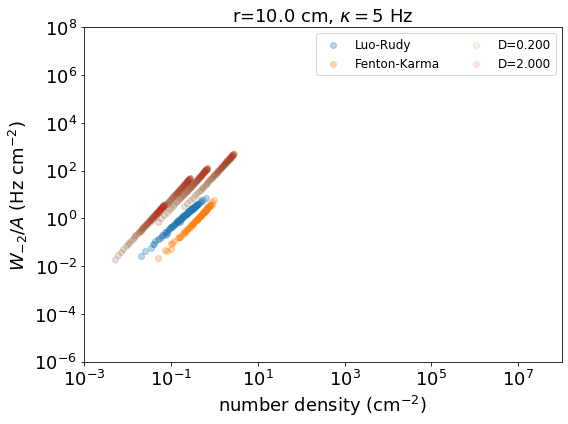

In [68]:
#plot over D
i,j=-1,1
r=r_values[i];kappa=kappa_values[j];yscale=10**3
print(f'r={r}, kappa={kappa}')
yscale=10**3

#plot the values
figsize=(8,6)
fontsize=18
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'model_comparison_r_{r}_k_{kappa}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#plot up results from full simulation
ax.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,label='Luo-Rudy')
ax.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,label='Fenton-Karma')

for D in D_values:#[0.2]:#:
    x_values,y_values=agg_over_A(r,D,kappa)
    if x_values is not None and x_values.shape[0]>0:
        #plot x,y values
        ax.scatter(x_values,y_values,label=f"D={D:.3f}",alpha=alpha)
        if np.isnan(y_values).any():
            print(f"D={D}")

    
ax.legend(loc='lower right')
ax.set_xlim([1e-3,1e+8])
ax.set_ylim([1e-6,1e+8])

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'number density (cm$^{-2}$)', fontsize=fontsize)
ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.legend(fontsize=fontsize-6,ncol=2)
ax.set_title(f'r={r} cm, '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [18]:
# #compute w_lr and w_fk using a linear regression of a log-log plot
# # from lib.compute_slope import *
# x_values,y_values=agg_over_A(r=0.2,D=.5,kappa=0.2)
# x=x_values
# y=y_values
# dict_out=compute_95CI_ols(np.log(x),np.log(y))
# dict_out

In [19]:
#TODO: filter to csv of slopes, Rsquared values and input parameters
# TODO: determine Nmin from raw
# Nmin=5#11.... Nmin=5 is currently ignored :(
#TODO: make function that maps a log file to a dict_out with mean stopping time values


In [20]:
# yscale=10**3
# for kappa in kappa_values:
#     #plot over r holding kappa fixed
#     #     i=2
#     #     kappa=kappa_values[i];
#     #     print(f'kappa={kappa}')

#     #plot the values
#     figsize=(8,6)
#     fontsize=18
#     saving=True
#     savefig_folder=f'{nb_dir}/../fig'
#     savefig_fn=f'ballistic_model_comparison_k_{kappa}.png'
#     fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#     #plot up results from full simulation
#     ax.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,c='C1',label='Luo-Rudy')
#     ax.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,c='C0',label='Fenton-Karma')

#     # for kappa in kappa_values:
#     for r in r_values:
#         x_values,y_values=agg_over_D(r,kappa)
#         if x_values is not None:
#             #plot x,y values
#             ax.scatter(x_values,y_values,label=f"r={r:.2f}",alpha=alpha)

            
#     ax.legend(loc='lower right')

#     # ax.set_xlim([0,1])
#     # ax.set_ylim([0,1])

#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim([1e-3,1e+6])
#     ax.set_ylim([1e-6,1e+6])

#     ax.set_xlabel(r'number density (cm$^{-2}$)', fontsize=fontsize)
#     ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
#     ax.tick_params(axis='both', which='major', labelsize=fontsize)
#     ax.tick_params(axis='both', which='minor', labelsize=0)
#     ax.legend(fontsize=fontsize-6,ncol=2)
#     ax.set_title(r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

#     fig.tight_layout()
#     if not saving:
#         plt.show()
#     else:
#         plt.tight_layout()
#         os.chdir(savefig_folder)
#         plt.savefig(savefig_fn, dpi=300)
#     #         print(f"saved figure in \n\t{savefig_fn}")
#         plt.close()

In [21]:
# # #plot over kappa holding r fixed
# # i=2
# # r=r_values[i];
# # print(f'r={r}')
# yscale=10**3
# for r in r_values:
#     #plot the values
#     figsize=(8,6)
#     fontsize=18
#     saving=True
#     savefig_folder=f'{nb_dir}/../fig'
#     savefig_fn=f'model_comparison_r_{r}.png'
#     fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#     #plot up results from full simulation
#     ax.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,c='C1',label='Luo-Rudy')
#     ax.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,c='C0',label='Fenton-Karma')

#     for kappa in kappa_values:
#         x_values,y_values=agg_over_D(r,kappa)
#         if x_values is not None:
#             #plot x,y values
#             ax.scatter(x_values,y_values,label=f"r={r:.2f}",alpha=alpha)



#     ax.legend(loc='lower right')

#     # ax.set_xlim([0,1])
#     # ax.set_ylim([0,1])

#     ax.set_yscale('log')
#     ax.set_xscale('log')
#     ax.set_xlim([1e-3,1e+6])
#     ax.set_ylim([1e-6,1e+6])
#     ax.set_xlabel(r'number density (cm$^{-2}$)', fontsize=fontsize)
#     ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
#     ax.tick_params(axis='both', which='major', labelsize=fontsize)
#     ax.tick_params(axis='both', which='minor', labelsize=0)
#     ax.legend(fontsize=fontsize-6,ncol=2)
#     ax.set_title(f'r={r} cm ', fontsize=fontsize)

#     fig.tight_layout()
#     if not saving:
#         plt.show()
#     else:
#         plt.tight_layout()
#         os.chdir(savefig_folder)
#         plt.savefig(savefig_fn, dpi=300)
#     #         print(f"saved figure in \n\t{savefig_fn}")
#         plt.close()

# comparing rmse at high densities
compute w versus q and find r,kappa with smalles RMSE_lr,fk

In [22]:
#get df into the right schema
#iterate over settings, counting the number of trials
count=0
dg_lst=[]
for r in r_values:
    for D in D_values:
        for kappa in kappa_values:
            count=count+1
            xv,yv=agg_over_A(r,D,kappa)
            if xv is not None:
                dg = pd.DataFrame({'q':xv,'w':yv})
                dg['r']=r
                dg['D']=D
                dg['kappa']=kappa
                dg_lst.append(dg)
print(count)

1694


In [23]:
# def routine(item):
#     r,D,kappa=item
#     return PlotUnivCurve(r,D,kappa)

# #run plotting in parallel
# b = db.from_sequence(queue, npartitions=9).map(routine)
# start = time.time()
# retval = list(b)
# print(f"run time was {time.time()-start:.2f} seconds.")
# beep(10)

In [24]:
dg=pd.concat(dg_lst)
dg.head()

ValueError: No objects to concatenate

In [ ]:
#compute w_lr and w_fk using a linear regression of a log-log plot
# from lib.compute_slope import *
yscale=10**3
x=lr.q.values
y=yscale*lr.w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_lr=dict_out.copy()
#predict the values functionally over all q
m=dict_out['m'];b=dict_out['b']
q_foo = lambda q: m*q+b
dg['w_lr']=np.exp(q_foo(np.log(dg['q'])))

x=fk.q.values
y=yscale*fk.w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_fk=dict_out.copy()
#predict the values functionally over all q
m=dict_out['m'];b=dict_out['b']
q_foo = lambda q: m*q+b
dg['w_fk']=np.exp(q_foo(np.log(dg['q'])))

In [ ]:
#compute the square errors 
dg['se_w_fk']=(dg['w']-dg['w_fk'])**2
dg['se_w_lr']=(dg['w']-dg['w_lr'])**2


In [ ]:
dg_fn='w_vs_q_agg_over_A.csv'
os.chdir(data_folder)
dg.to_csv(dg_fn,index=False)

In [ ]:
qmin=0.3;qmax=1.;
#compute the root mean squared errors over various axes
kappa_lst=[];r_lst=[];rmse_lr_lst=[];rmse_fk_lst=[];
for r in r_values:
    for kappa in kappa_values:
#         print(f"for r={r}, kappa={kappa},")
        query=(dg.r==r)&(dg.kappa==kappa)&(dg.q>qmin)&(dg.q<qmax)
        qu=dg[query]
        rmse_lr=np.sqrt(qu.se_w_lr.mean())
        rmse_fk=np.sqrt(qu.se_w_fk.mean())
#         print(f"\tRMSE = {rmse_lr:.6f} (LR) and RMSE = {rmse_fk:.6f} (FK)")
        r_lst.append(r)
        kappa_lst.append(kappa)
        rmse_lr_lst.append(rmse_lr)
        rmse_fk_lst.append(rmse_fk)

In [ ]:
dh=pd.DataFrame({
    'r':r_lst,
    'kappa':kappa_lst,
    'rmse_lr':rmse_lr_lst,
    'rmse_fk':rmse_fk_lst,
    
})

In [ ]:
#and the top 5 matches for either model is... (FK)
print(f"The top 5 for the Fenton-Karma model:")
dh.sort_values(by='rmse_fk').head()

In [ ]:
#plot over D the top 5 results for the FK model
r=0.85;kappa=5;
# r=0.6;kappa=10;
# r=0.5;kappa=15;
# r=0.4;kappa=25;
# r=0.8;kappa=5;

# r=0.2;kappa=100;
yscale=10**3

#plot the values
figsize=(6,4)
fontsize=18
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'fk_model_comparison_r_{r}_k_{kappa}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#plot up results from full simulation
# ax.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,label='Luo-Rudy')
ax.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,label='Fenton-Karma')

for D in [0.2,2]:#D_values:
    x_values,y_values=agg_over_A(r,D,kappa)
    #plot x,y values
    ax.scatter(x_values,y_values,label=f"D={D:.2f}",alpha=alpha,s=10)

    
ax.legend(loc='lower right')

# ax.set_xlim([0,1])
# ax.set_ylim([0,1])

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([1e-3,1e+6])
# ax.set_ylim([1e-6,1e+6])

ax.set_xlabel(r'number density (cm$^{-2}$)', fontsize=fontsize)
ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.legend(fontsize=fontsize-2,ncol=1)
ax.set_title(f'r={r} cm '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#         plt.close()

In [ ]:
#and the top 5 matches for either model is... (LR)
print(f"The top 5 for the Luo-Rudy model:")
dh.sort_values(by='rmse_lr').head()

In [ ]:
#plot over D the top 5 results for the LR model
r=0.8;kappa=20;
r=0.65;kappa=30;
r=0.6;kappa=35;
r=0.90;kappa=15;
r=0.95;kappa=15;

# r=0.2;kappa=100;
yscale=10**3

#plot the values
figsize=(6,4)
fontsize=18
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'lr_model_comparison_r_{r}_k_{kappa}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#plot up results from full simulation
ax.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,label='Luo-Rudy')
# ax.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,label='Fenton-Karma')

for D in [0.2,2]:#D_values:
    x_values,y_values=agg_over_A(r,D,kappa)
    #plot x,y values
    ax.scatter(x_values,y_values,label=f"D={D:.2f}",alpha=alpha,s=10)

    
ax.legend(loc='lower right')

# ax.set_xlim([0,1])
# ax.set_ylim([0,1])

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([1e-3,1e+6])
# ax.set_ylim([1e-6,1e+6])

ax.set_xlabel(r'number density (cm$^{-2}$)', fontsize=fontsize)
ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.legend(fontsize=fontsize-2,ncol=1)
ax.set_title(f'r={r} cm '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#         plt.close()

In [ ]:
#try some root finding for mse_fk,lr(r,k) for D = 2.0 fixed
#compute the root mean squared errors over various axes
kappa_lst=[];r_lst=[];rmse_lr_lst=[];rmse_fk_lst=[];
for r in r_values:
    for kappa in kappa_values:
#         print(f"for r={r}, kappa={kappa},")
        query=(dg.r==r)&(dg.kappa==kappa)&(dg.D==2.0)
        qu=dg[query]
        rmse_lr=np.sqrt(qu.se_w_lr.mean())
        rmse_fk=np.sqrt(qu.se_w_fk.mean())
#         print(f"\tRMSE = {rmse_lr:.6f} (LR) and RMSE = {rmse_fk:.6f} (FK)")
        r_lst.append(r)
        kappa_lst.append(kappa)
        rmse_lr_lst.append(rmse_lr)
        rmse_fk_lst.append(rmse_fk)

In [ ]:
beep(10)

In [ ]:

dh_fn='rmse_by_kappa_r_agg_over_A_D.csv'
os.chdir(data_folder)
dh.sort_values(by='rmse_lr').to_csv(dh_fn,index=False)

In [ ]:
#compute w_lr and w_fk using a linear regression of a log-log plot
# from lib.compute_slope import *
yscale=10**3
query=fk.q>qmin
x=fk[query].q.values
y=yscale*fk[query].w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_out

In [ ]:
#compute w_lr and w_fk using a linear regression of a log-log plot
# from lib.compute_slope import *
yscale=10**3
query=lr.q>qmin
x=lr[query].q.values
y=yscale*lr[query].w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_out

# comparing/fitting slopes at high densities
-TODO: plot lr and fk in excel with lines and equations shown on log log plot


In [ ]:
#DONE: save dg and dh as csv
#TODO: save lr and fk as csv
#TODO: plot lr and fk in excel with lines and equations shown on log log plot

#TODO: compute slope of each parameter setting in the range [qmin,qmax]
#TODO: find parameter settings that match in slope and have low rmse for lr or fk
#TODO: start simulation on those settings with a wide range of number densities for each promising r,D,kappa item

# TODO: collect results in one page .pdf
#   - effect of increasing r
#   - effect of increasing kappa
#   - effect on increasing D at low densities
#   - simple way to scale r,D,kappa onto the same axis?

# simple way to scale r,D,kappa onto the same axis for d~unity

In [ ]:
os.chdir(data_folder)
dg_fn='w_vs_q_agg_over_A.csv'
dg=pd.read_csv(dg_fn)

In [ ]:
dg.head()

In [ ]:
dg['d']=np.pi*dg.r**2*dg.q
dg['u']=dg.w/dg.kappa*np.pi*dg.r**2
dg['c']=1/dg.D*(np.pi*dg.r**2*dg.kappa)

In [ ]:
x_values=dg.d.values
y_values=dg.u.values
c_values=dg.c.values

#plot the values
figsize=(6,5)
fontsize=18
saving=False
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'univ_curve_bgmc.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

ax.scatter(x_values,y_values,alpha=0.1,c=c_values, cmap='Reds',s=5)

# ax.legend(loc='lower right')
ax.set_xlim([1e-4,1e+8])
ax.set_ylim([1e-6,1e+8])

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r'd', fontsize=fontsize)
# ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize-6,ncol=2)
# ax.set_title(f'r={r} cm, '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

# computing mean values from merged cloud output

In [ ]:
#get df into the right schema
#iterate over settings, counting the number of trials
count=0
df_mean_lst=[]
for r in r_values:
    for D in D_values:
        for kappa in kappa_values:
            for L in L_values:
                #get slice
                query=(df.r==r)&(df.D==D)&(df.L==L)&(df.kappa==kappa)
                dff=df[query].copy().drop(columns=['r','D','L','kappa'])
                if dff.size>0:
                    #compute x,y values
                    A=L**2
                    dfd=dff.mean()
                    xv=np.array([eval(iv) for iv in dfd.index.values])/A
                    yv=dfd.values.copy()**-1/A
                    if xv is not None:
                        df_mean = pd.DataFrame({'q':xv,'w':yv})
                        df_mean['A']=A
                        df_mean['r']=r
                        df_mean['D']=D
                        df_mean['kappa']=kappa
                        df_mean_lst.append(df_mean)
                        count=count+1
print(count)
df_mean=pd.concat(df_mean_lst)

In [ ]:
dfm_fn='df_mean_run_6.csv'
# dfm_fn='df_mean_runs_1_to_3.csv'
os.chdir(data_folder)
df_mean.to_csv(dfm_fn,index=False)

# visualizing first order universal curve

In [ ]:
os.chdir(data_folder)
dg_fn='df_mean_run_6.csv'
# dg_fn='df_mean_runs_1_to_3.csv'
dg=pd.read_csv(dg_fn)

In [ ]:
dg['d']=np.pi*dg.r**2*dg.q
dg['u']=dg.w/dg.kappa*np.pi*dg.r**2
# dg['c']=dg.D/(dg.kappa)/dg.A
dg['c']=dg.A

In [ ]:
query=(dg.d>=1)&(dg.d<=3)
x=dg[query].d.values
y=dg[query].u.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_out

In [ ]:
# generate linear data
ld_values=np.linspace(-10,10,81)
lu_values=dict_out['m']*ld_values + dict_out['b']
# ld_values

In [ ]:
eqn_text=u'$\log(u)=2.054(2)\;\log(d)$\n\t\t$- 0.698(1)$\n\t\t$R^2=0.993$'

In [ ]:
x_values=dg.d.values
y_values=dg.u.values
c_values=np.log(dg.c.values)

#plot the values
figsize=(7,7)
fontsize=20
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'univ_curve_bgmc_first_order.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#plot axes
ax.plot(np.exp(ld_values),1+0*np.exp(lu_values),'--',c='k',lw=3,alpha=.5,label='x axis')
ax.plot(1+0*np.exp(ld_values),np.exp(lu_values),'--',c='k',lw=3,alpha=.5,label='y axis')

#plot results
ax.scatter(x_values,y_values,alpha=0.05,c=c_values, cmap='Blues',s=1,label='simulation')
ax.plot(np.exp(ld_values),np.exp(lu_values),c='black',lw=3,alpha=.8,label='linear fit')

# ax.legend(loc='lower right')
ax.set_xlim([1e-4,1e+4])
ax.set_ylim([1e-8,1e+8])

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'u',fontsize=fontsize)
ax.set_xlabel(r'd', fontsize=fontsize)
# ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize-6,ncol=2)
# ax.set_title(f'r={r} cm, '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

ax.annotate(eqn_text, xy=(0.8, 1.1), xytext=(.0005, 100),fontsize=fontsize-8,
            arrowprops=dict(facecolor='white', shrink=1.0,edgecolor='white'),
            )

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [ ]:
# DONE: compute slope of ^this curve near the origin
# DONE: plot ^that line and annotate the equation
print((np.exp(-0.697),np.exp(-0.698),np.exp(-0.699)))

$$
d =\frac{N\pi r^2}{A},\quad u=\frac{W_{-2}\pi r^2}{\kappa A}
$$

__Corollary__<br>
 We observe that $m=2.054(2)$ and $b=0.698(1)$ for $d\in[1,3]$ in the equation
$$\log(u)=m\log(d)-b.$$
 
<!-- $$\log(u)=\log(d^m)-\log(e^b)$$
$$\log(u)=\log(d^me^{-b})$$
$$u=d^me^{-b}$$
 -->
Substituting,

$$
\frac{W_{-2}\pi r^2}{\kappa A} = e^{-b}\Big(\frac{N\pi r^2}{A}\Big)^m
$$

Noting $e^{-b}=0.4975(5)\approx1/2$ and $m=2.054(2)\approx 2$,<br>
we may approximate for $d\sim 1$,

$$
\frac{W_{-2}\pi r^2}{\kappa A} \approx \frac{1}{2}\Big(\frac{N\pi r^2}{A}\Big)^2
$$
Suggesting
$$
W_{-2}\approx \frac{\kappa\pi r^2}{2A} N^2
$$

Or for $w=W_{-2}/A$ and $q=N/A$,

$$
w\approx \frac{\kappa\pi r^2}{2} q^2
$$

Suggesting the exponential of the y-intercept of the log(w)-log(q) plot is approximately $B\equiv\frac{\kappa\pi r^2}{2}$.





dudududu

In [ ]:
#compute w_lr and w_fk using a linear regression of a log-log plot
yscale=10**3
query=fk.q>0.3
x=fk[query].q.values
y=yscale*fk[query].w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_out

In [ ]:
#compute w_lr and w_fk using a linear regression of a log-log plot
yscale=10**3
query=lr.q>0.3
x=lr[query].q.values
y=yscale*lr[query].w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
dict_out

In [ ]:
print((np.exp(1.7),np.exp(1.73),np.exp(1.76)))
print((np.exp(2.72-.07),np.exp(2.72),np.exp(2.72+0.07)))

The death rate for the Fenton-Karma model near $d\sim1$ has $m=1.98(4)\approx 2$ and should approximately support the relation $e^{1.73(3)}= 5.6(2) \text{cm}^2/\text{s} \approx B=\frac{1}{2}\kappa \pi r^2$.

The death rate for the Luo-Rudy model near $d\sim1$ has $m=1.51(7)\approx 3/2$ and shouldn't approximately support the relation $e^{2.72(7)}=14\pm1 \text{cm}^2/\text{s}\approx B=\frac{1}{2}\kappa \pi r^2$.


In [ ]:
x_values=dg.d.values
y_values=dg.u.values
c_values=np.log(dg.c.values)

#plot the values
figsize=(7,7)
fontsize=20
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'univ_curve_bgmc_first_order_zoomed.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#plot axes
ax.plot(np.exp(ld_values),1+0*np.exp(lu_values),'--',c='k',lw=3,alpha=.5,label='x axis')
ax.plot(1+0*np.exp(ld_values),np.exp(lu_values),'--',c='k',lw=3,alpha=.5,label='y axis')

#plot results
ax.scatter(x_values,y_values,alpha=0.15,c=c_values, cmap='Blues',s=5,label='simulation')
ax.plot(np.exp(ld_values),np.exp(lu_values),c='black',lw=3,alpha=.8,label='linear fit')

# ax.legend(loc='lower right')
ax.set_xlim([1e-1,1e+1])
ax.set_ylim([1e-5,1e+3])

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylabel(r'u',fontsize=fontsize)
ax.set_xlabel(r'd', fontsize=fontsize)
# ax.set_ylabel(r'$W_{{-2}}/A$ (Hz cm$^{-2}$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize-6,ncol=2)
# ax.set_title(f'r={r} cm, '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

ax.annotate(eqn_text, xy=(0.9, 1.1), xytext=(0.15, 10),fontsize=fontsize-8,
            arrowprops=dict(facecolor='white', shrink=1.0, edgecolor='white'),
            )

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

In [ ]:
#TODO: test compute b for 5 highest scoring simulations for fk model
calc_b = lambda r,k:0.5*k*np.pi*r**2
print('B for 5 highest scoring simulations for FK model:')
print(calc_b(.6,10))
print(calc_b(.85,5))
print(calc_b(.5,15))
print(calc_b(.4,25))
print(calc_b(.8,5))

print(f"the predicted B value for the FK model is:")
print(np.exp(1.7276866248433098))

In [ ]:
print('B for 5 highest scoring simulations for LR model:')
print(calc_b(.8,20))
print(calc_b(.65,30))
print(calc_b(.6,35))
print(calc_b(.9,15))
print(calc_b(.95,15))
print(f"the predicted B value for the LR model is:")
print(np.exp(2.718534204162766))

# TODO(later):  search for higher order universal curve for d far from unity


In [ ]:
dg['d']=np.pi*dg.r**2*dg.q
dg['u']=dg.w/dg.kappa*np.pi*dg.r**2
dg['c']=dg.D/(dg.A*dg.kappa)
# dg['c']=dg.A#/(np.pi*dg.r**2)
# dg['c']=dg.A

x_values=np.log(dg.d.values)
y_values=np.log(dg.u.values)
c_values=np.log(dg.c.values)

y_values=y_values - (x_values**1)/(c_values) #+ x_values*c_values**(1)
# x_values=x_values + x_values*(c_values**1)

#plot the values
figsize=(6,5)
fontsize=18
saving=False
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'univ_curve_bgmc_higher_order.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

ax.scatter(x_values,y_values,alpha=0.1,c=c_values, cmap='Reds',s=5)

# # ax.legend(loc='lower right')
ax.set_xlim([-2,2])
ax.set_ylim([-10,10])

# ax.set_yscale('log')
# ax.set_xscale('log')

ax.set_xlabel(r'log(d)', fontsize=fontsize)
ax.set_ylabel(r'log(u`)',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize-6,ncol=2)
# ax.set_title(f'r={r} cm, '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

# plot lr,fk curves with linear fits annotated

In [ ]:
#compute w_lr and w_fk using a linear regression of a log-log plot
yscale=10**3
query=fk.q>0.3
x=fk[query].q.values
y=yscale*fk[query].w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
m_fk=dict_out['m'];b_fk=dict_out['b']
dict_out

In [ ]:
#compute w_lr and w_fk using a linear regression of a log-log plot
query=lr.q>0.3
x=lr[query].q.values
y=yscale*lr[query].w.values
dict_out=compute_95CI_ols(np.log(x),np.log(y))
m_lr=dict_out['m'];b_lr=dict_out['b']
dict_out

In [ ]:
fk_text=u'$\log(w/1_w)=1.98(4)\;\log(q/1_q)$\n\t\t$+1.73(3)$\n\t\t$R^2=0.995$'
lr_text=u'$\log(w/1_w)=1.50(7)\;\log(q/1_q)$\n\t\t$2.72(7)$\n\t\t$R^2=0.987$'

In [ ]:
# generate linear data
log_x_values=np.linspace(-10,10,81)
log_y_values_lr=m_lr*log_x_values +b_lr
log_y_values_fk=m_fk*log_x_values +b_fk


In [ ]:
#plot up WJ's results
plt.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,c='C1',label='Luo-Rudy')
plt.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,c='C0',label='Fenton-Karma')


# plt.ylim([1e-5,1e-2])
plt.yscale('log')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
#plot the values
figsize=(12,6)
fontsize=20
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'full_model_results.png'
fig, axs = plt.subplots(ncols=2,figsize=figsize)# ax=axs[1]

#Luo-Rudy model
ax=axs[0]
#plot axes
ax.plot(np.exp(log_x_values),1+0*np.exp(log_y_values_lr),'--',c='k',lw=3,alpha=.5,label='x axis')
ax.plot(1+0*np.exp(log_x_values),np.exp(log_y_values_lr),'--',c='k',lw=3,alpha=.5,label='y axis')
#plot results
ax.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,c='C1',label='Luo-Rudy')
ax.plot(np.exp(log_x_values),np.exp(log_y_values_lr),c='C1',lw=3,alpha=.8,label='linear fit')
ax.set_xlim([1e-2,2e+0])
ax.set_ylim([1e-2,2e+1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
ax.set_ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_title(f'Luo-Rudy Model', fontsize=fontsize)
ax.annotate(lr_text, xy=(.02, 2), xytext=(.02, 2),fontsize=fontsize-8,
            arrowprops=dict(facecolor='white', shrink=1.0,edgecolor='white'))
# ax.legend(fontsize=fontsize)

#Fenton-Karma model
ax=axs[1]
#plot axes
ax.plot(np.exp(log_x_values),1+0*np.exp(log_y_values_fk),'--',c='k',lw=3,alpha=.5,label='x axis')
ax.plot(1+0*np.exp(log_x_values),np.exp(log_y_values_fk),'--',c='k',lw=3,alpha=.5,label='y axis')
#plot results
ax.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,c='C0',label='Fenton-Karma')
ax.plot(np.exp(log_x_values),np.exp(log_y_values_fk),c='C0',lw=3,alpha=.8,label='linear fit')
ax.set_xlim([1e-2,2e+0])
ax.set_ylim([1e-2,2e+1])
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
ax.set_ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.set_title(f'Fenton-Karma Model', fontsize=fontsize)
ax.annotate(fk_text, xy=(.02, 2), xytext=(.02, 2),fontsize=fontsize-8,
            arrowprops=dict(facecolor='white', shrink=1.0,edgecolor='white'))
# ax.legend(fontsize=fontsize)

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()

# Measuring slope for all mean slopes

In [ ]:
from lib.compute_sliding_slope import *


In [ ]:
#import mean results
os.chdir(data_folder)
df_fn='df_mean_runs_1_to_3.csv'
df=pd.read_csv(df_fn)
# df.head()
df['d']=np.pi*df.r**2*df.q
df['u']=df.w/df.kappa*np.pi*df.r**2
# dg['c']=dg.D/(dg.kappa)/dg.A
df['c']=df.A
df['x']=np.log(df.d)
df['y']=np.log(df.u)

In [ ]:
#extract column values
r_values=np.array(sorted(set(df.r.values)))#cm
D_values=np.array(sorted(set(df.D.values)))#cm^2/s
A_values=np.array(sorted(set(df.A.values)))#cm^2
# L_values**2#cm^2
kappa_values=np.array(sorted(set(df.kappa.values)))#1/s

In [ ]:
# r=r_values[0];D=D_values[0];A=A_values[1];kappa=kappa_values[1]
xavg_values_lst=[];slope_values_lst=[];Rsquared_values_lst=[];
r_lst=[];D_lst=[];A_lst=[];kappa_lst=[]
for r in r_values:
    for D in D_values:
        for A in A_values:
            for kappa in kappa_values:
                query=(df.r==r)&(df.D==D)&(df.A==A)&(df.kappa==kappa)
                dff=df[query].copy()#.drop(columns=['r','D','A','kappa'])
                boo=dff.size>0
                if boo:
                    #measure dlogu_dlogd versus d
                    x_values=dff.d.values
                    y_values=dff.u.values
                    xavg_values,slope_values,Rsquared_values = compute_sliding_slope_loglog(x_values,y_values)
                    #record the results
                    xavg_values_lst.append(xavg_values)
                    slope_values_lst.append(slope_values)
                    Rsquared_values_lst.append(Rsquared_values)
                    r_lst.append(r);D_lst.append(D);A_lst.append(A);kappa_lst.append(kappa)
beep(4)

In [ ]:
figsize=(6,5)
fontsize=18
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'log_log_slope_runs_1_to_3.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]
zlst=zip(xavg_values_lst,slope_values_lst,Rsquared_values_lst)
#plot the values
for xavg_values,slope_values,Rsquared_values in zlst:
    ax.plot(xavg_values,slope_values,lw=1,label="_Hidden",alpha=0.3,color='gray')
    # ax.plot(xavg_values,Rsquared_values,lw=2,label="_Hidden")

#plot the reference lines
xv=np.linspace(1e-3,1e3,100)    
ax.plot(xv,2+0*xv,'-',color='k',label='quadratic')
ax.plot(xv,1+0*xv,'--',color='k',label='linear')

#format plot
ax.set_xlabel(r'$d$', fontsize=fontsize)
ax.set_ylabel(r'$\frac{\partial \log\,u}{\partial \log\,d}$', fontsize=fontsize+4)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
ax.legend(fontsize=fontsize-4,ncol=2,loc='lower right')
# ax.set_title(f'r={r} cm, '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)
# ax.set_xlim([1e-3,1e+8])
# ax.set_ylim([1e-6,1e+8])
# ax.set_yscale('log')
ax.set_xscale('log')
fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()


In [ ]:
figsize=(6,5)
fontsize=18
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'log_log_Rsquared_runs_1_to_3.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]
zlst=zip(xavg_values_lst,slope_values_lst,Rsquared_values_lst)
#plot the values
for xavg_values,slope_values,Rsquared_values in zlst:
    ax.plot(xavg_values,Rsquared_values,lw=1,label="_Hidden",alpha=0.3,color='gray')
#     ax.plot(xavg_values,Rsquared_values,lw=2,label="_Hidden")

#plot the reference lines
# xv=np.linspace(1e-3,1e3,100)    
# ax.plot(xv,2+0*xv,'-',color='k',label='quadratic')
# ax.plot(xv,1+0*xv,'--',color='k',label='linear')

#format plot
ax.set_xlabel(r'$d$', fontsize=fontsize)
ax.set_ylabel(r'$R^2$', fontsize=fontsize+4)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)
# ax.legend(fontsize=fontsize-4,ncol=2,loc='lower right')
# ax.set_title(f'r={r} cm, '+r'$\kappa=$'+f'{kappa} Hz', fontsize=fontsize)
# ax.set_xlim([1e-3,1e+8])
# ax.set_ylim([1e-6,1e+8])
# ax.set_yscale('log')
ax.set_xscale('log')
fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#     plt.close()


# root cause analysis of subquadratic trials

In [ ]:
#root cause analysis/ find what all those subquadratic curves have in common.  
# Do they all exhibit A=1000 cm^2?  Yes.
# If so, do the corresponding r,D,kappa behave a similar way for smaller A?
slope_thresh=1.5
boo_lst=[];boonan_lst=[]
for sv in slope_values_lst:
    boo=(sv<slope_thresh).any()
    boo_lst.append(boo)
    boonan=np.isnan(sv).any()
    boonan_lst.append(boonan)
boo_values=np.array(boo_lst)
boonan_values=np.array(boonan_lst)

In [ ]:
sum(boo_values)
# sum(boonan_values)

In [ ]:
assert (np.array(A_lst)[boo_values]>=1000).all()
print(f"all trials with slope less than 1.5 had area of 1000 cm^2")

In [ ]:
print('(r,D,kappa) values that were subquadratic:')
print(list(zip(np.array(r_lst)[boo_values],np.array(D_lst)[boo_values],np.array(kappa_lst)[boo_values])))

In [ ]:
print('r values that were subquadratic:')
print(np.array(r_lst)[boo_values])
print('\nD values that were subquadratic:')
print(np.array(D_lst)[boo_values])
print('\nkappa values that were subquadratic:')
print(np.array(kappa_lst)[boo_values])

In [ ]:
kv=np.array(kappa_lst)[boo_values]
rv=np.array(r_lst)[boo_values]
Dv=np.array(D_lst)[boo_values]
Bv=0.5*np.pi*rv**2*kv
print('B values that were subquadratic:')
print(Bv)

In [ ]:
bid=-8
print(f'the B={Bv[bid]} value close to that of the FK model had (r,D,kappa)={(rv[bid],Dv[bid],kv[bid])}')

In [ ]:
# # i,j,k=2,0,2
# # i,j,k=2,-1,-1
# i,j,k=-5,-1,2
# i,j,k=-5,0,2
# #one test case
# r=r_values[i];D=D_values[j];kappa=kappa_values[k];yscale=10**3
yscale=10**3
r=0.2;D=0.2;kappa=90
print(f'r={r}, D={D}, kappa={kappa}')
#plot the values
figsize=(6,5)
fontsize=18
saving=True
savefig_folder=f'{nb_dir}/../fig'
savefig_fn=f'area_dependent_turning_point_r_{r}_D_{D}_k_{kappa}.png'
fig, ax = plt.subplots(ncols=1,figsize=figsize)# ax=axs[1]

#plot up results from full simulation
ax.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,label='Luo-Rudy')
ax.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,label='Fenton-Karma')
ax.set_title(f'r={r} cm, D={D} '+r'cm$^{2}/s$, $\kappa=$'+f'{kappa} Hz', fontsize=fontsize)

#plot up results from simple monte carlo simulation
retval=GetPlotUnivCurve(r,D,kappa,ax,alpha=0.3)
ax.legend(loc='best',fontsize=fontsize-10,ncol=2)
# ax.set_xlim([0,1])
# ax.set_ylim([0,1])
plt.ylim([1e-8,1e+6])
ax.set_yscale('log')
ax.set_xscale('log')

fig.tight_layout()
if not saving:
    plt.show()
else:
    plt.tight_layout()
    os.chdir(savefig_folder)
    plt.savefig(savefig_fn, dpi=300)
#         print(f"saved figure in \n\t{savefig_fn}")
#         plt.close()

In [ ]:
print('r values that had nan:')
print(np.array(r_lst)[boonan_values])
# print('\nD values that had nan:')
# print(np.array(D_lst)[boonan_values])
print('\nkappa values that had nan:')
print(np.array(kappa_lst)[boonan_values])

In [ ]:
#all trials with slope less than 1.5 had area of 1000 cm^2
(np.array(A_lst)[boonan_values]>=1000)

In [ ]:
kv=np.array(kappa_lst)[boonan_values]
rv=np.array(r_lst)[boonan_values]
Bv=0.5*np.pi*rv**2*kv
print('B values that had nan:')
print(Bv)

In [ ]:
#TODO: measure B for lr and fk using ols on sqrt(w) versus q

In [ ]:
Bv[-8]

In [ ]:
print("r values considered")
print(r_values)
print("\nD values considered")
print(D_values)
print("\nkappa values considered")
print(kappa_values)
print("\nA values considered")
print(A_values)

$$
B=\frac{1}{2}\kappa\pi r^2 \implies \kappa = \frac{2B}{\pi r^2}
$$


In [ ]:
#TODO(later for smaller CI): estimate B from slope of sqrt rate density (FK) and (later) from slope of pow(w,2/3) (LR)  
#TODO: estimate kappa for FK model
B = 5.62376
calc_kappa = lambda B,r: 2*B/(np.pi * r**2)
print(f"From the y-intercept of the log-log plot,")
print(f"\tthe FK model has B={B} cm$^2$/s.")
print('Then,')
for r in [0.1,0.2,0.3,0.4,0.5]:
    print(f"\tfor r = {r:.1f} cm, kappa = {calc_kappa(B,r):.0f} Hz.")

# fits to phenomenological power law model

Let 
$$
w=B*q^m
$$

Then, the best linear unbiased estimator for $B$ is computed from OLS of $w^{1/m}$ versus $q$, supposing sufficient goodness of fit.

__Method__
- measure m,Delta_m in log-log plot, considering only q<q_thresh
- measure B,Delta_B in lin-lin plot of w^{1/m} versus q, considering only q<q_thresh

- TODO: Measure m,B for LR, FK model
- TODO: Measure m,B for each trial of run 6
- TODO: rank trials in terms of mean squared error of m and B for each trial

- TODO(and then): estimate turning points

In [171]:
#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)

data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'

fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A'] #[mHz?]/cm^2

lr=pd.read_csv(data_lr_fn)
lr['N']=lr['No2']*2
lr['q']=lr['N']/lr['A'] #number of tips per square centimeter
lr['w']=lr['rate']/lr['A'] #[mHz?]/cm^2

In [172]:
#  TODO: Measure B for full model
yscale=10**3
fn=os.path.basename(data_fk_fn)
fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A'] #[mHz?]/cm^2
# query=(fk.q>0.2)&(fk.q<1.)#fk.q<0.7#<0.2
x=fk.q.values
y=yscale*fk.w.values
print('\n'+fn)
print_fit_power_law(x,y)

fn=os.path.basename(data_lr_fn)
fk=pd.read_csv(data_lr_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A'] #[mHz?]/cm^2
# query=(fk.q>0.2)&(fk.q<1.)#fk.q<0.7#<0.2
x=fk.q.values
y=yscale*fk.w.values
print('\n'+fn)
print_fit_power_law(x,y)


data_fig4_vidmar_fk_tt.csv
m=1.877+-0.025; B=2.497+-0.040
M=B**m=5.57+-0.31 Hz*cm^{2(m-1)}
RMSE=0.1386 Hz/cm^2
R^2=0.997

data_fig4_vidmar_lr_tt.csv
m=1.638+-0.017; B=5.588+-0.067
M=B**m=16.74+-0.85 Hz*cm^{2(m-1)}
RMSE=0.1340 Hz/cm^2
R^2=0.997


In [196]:
#compute w_lr and w_fk using a linear regression of a log-log plot
yscale=10**3
query=(fk.q>0.2)&(fk.q<1.)#fk.q<0.7#<0.2
x=fk[query].q.values
y=yscale*fk[query].w.values
dict_fk_loglog=compute_95CI_ols(np.log(x),np.log(y))
# dict_fk_loglog
# #fk
# dict_fk_loglog={'m': 1.9447060275370367,
#  'Delta_m': 0.029617122208703113,
#  'b': 1.7091950494051997,
#  'Delta_b': 0.024489019143397704,
#  'Rsquared': 0.9967057268076673}
m_fk=dict_fk_loglog['m']
Delta_m_fk=dict_fk_loglog['Delta_m']

#fk
dict_out=compute_95CI_ols(x,y**(1/m_fk))
dict_out
dict_fk_linlin=dict_out
B_fk=dict_fk_linlin['m']
Delta_B_fk=dict_fk_linlin['Delta_m']
# dict_fk_linlin

#lr
yscale=10**3
query=(lr.q>0.2)&(lr.q<1.)#lr.q<0.7#>0.2
x=lr[query].q.values
y=yscale*lr[query].w.values
dict_lr_loglog=compute_95CI_ols(np.log(x),np.log(y))
m_lr=dict_lr_loglog['m']
Delta_m_lr=dict_lr_loglog['Delta_m']


#lr
dict_out=compute_95CI_ols(x,y**(1/m_lr))
dict_lr_linlin=dict_out
B_lr=dict_lr_linlin['m']
Delta_B_lr=dict_lr_linlin['Delta_m']


print(f"m_fk={m_fk:.3f}+-{Delta_m_fk:.3f}; B_fk={B_fk:.3f}+-{Delta_B_fk:.3f}")
print(f"m_lr={m_lr:.3f}+-{Delta_m_lr:.3f}; B_lr={B_lr:.3f}+-{Delta_B_lr:.3f}")

def comp_power_scale(B,Delta_B,m,Delta_m):
    '''compute pessemistic 95% CI of annihilation rate scale, M_fk=B_fk**m_fk'''
    #min bound
    min_bound=(B-Delta_B)**(m-Delta_m)
    # print(B**m-min_bound)
    #max bound
    max_bound=(B+Delta_B)**(m+Delta_m)
    # print(max_bound-B**m)
    Delta_M=np.max((max_bound-B**m,B**m-min_bound))
    M=B**m
    return M,Delta_M

#compute pessemistic 95% CI of annihilation rate scale, M_fk=B_fk**m_fk
B=B_fk
m=m_fk
Delta_m=Delta_m_fk
Delta_B=Delta_B_fk
M_fk, Delta_M_fk= comp_power_scale(B,Delta_B,m,Delta_m)

B=B_lr
m=m_lr
Delta_m=Delta_m_lr
Delta_B=Delta_B_lr
M_lr, Delta_M_lr= comp_power_scale(B,Delta_B,m,Delta_m)

print(f"M_fk=B_fk**m_fk={M_fk:.2f}+-{Delta_M_fk:.2f} Hz*cm^{{2(m-1)}}")
print(f"M_lr=B_lr**m_lr={M_lr:.2f}+-{Delta_M_lr:.2f} Hz*cm^{{2(m-1)}}")

def compute_power_rmse(x_values,y_values,m,B):
    """compute rmse of power law fits"""
    yv=(B*x_values)**m
    rmse=np.sqrt(np.mean((y_values-yv)**2))
    return rmse

x_values=fk.q.values
y_values=yscale*fk.w.values
m=m_fk
B=B_fk
rmse_fk=compute_power_rmse(x_values,y_values,m,B)
print(f"RMSE_fk={rmse_fk:.4f} Hz/cm^2")

x_values=lr.q.values
y_values=yscale*lr.w.values
m=m_lr
B=B_lr
rmse_lr=compute_power_rmse(x_values,y_values,m,B)
print(f"RMSE_lr={rmse_lr:.4f} Hz/cm^2")

print(f"R^2={dict_fk_loglog['Rsquared']:.3f} (FK)")
print(f"R^2={dict_lr_loglog['Rsquared']:.3f} (LR)")



m_fk=1.945+-0.030; B_fk=2.441+-0.051
m_lr=1.544+-0.034; B_lr=5.870+-0.137
M_fk=B_fk**m_fk=5.67+-0.39 Hz*cm^{2(m-1)}
M_lr=B_lr**m_lr=15.37+-1.57 Hz*cm^{2(m-1)}
RMSE_fk=0.1252 Hz/cm^2
RMSE_lr=0.0974 Hz/cm^2
R^2=0.997 (FK)
R^2=0.994 (LR)


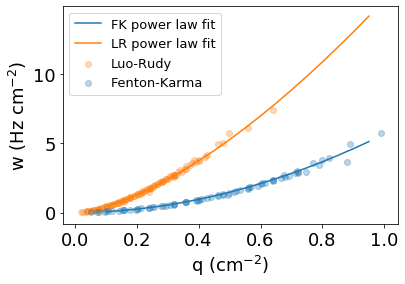

In [184]:
xv=np.arange(0.1,1.,.05)
yv_fk=(B_fk*xv)**m_fk
yv_lr=(B_lr*xv)**m_lr

yscale=10**3
fontsize=18
#plot up WJ's results
plt.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,c='C1',label='Luo-Rudy')
plt.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,c='C0',label='Fenton-Karma')
# plt.ylim([1e-5,1e-2])
# plt.yscale('log')
# plt.xscale('log')
plt.plot(xv,yv_fk,label='FK power law fit')
plt.plot(xv,yv_lr,label='LR power law fit')
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5)
plt.show()


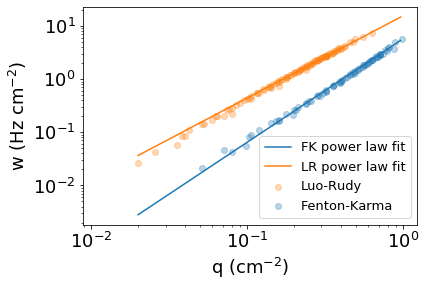

In [185]:


yscale=10**3
fontsize=18
#plot up WJ's results
plt.scatter(x=lr.q.values,y=yscale*lr.w.values,alpha=0.3,c='C1',label='Luo-Rudy')
plt.scatter(x=fk.q.values,y=yscale*fk.w.values,alpha=0.3,c='C0',label='Fenton-Karma')
# plt.ylim([1e-5,1e-2])
plt.yscale('log')
plt.xscale('log')

xv=np.arange(0.02,1.,.05)
yv_fk=(B_fk*xv)**m_fk
yv_lr=(B_lr*xv)**m_lr
plt.plot(xv,yv_fk,label='FK power law fit')
plt.plot(xv,yv_lr,label='LR power law fit')
plt.xlabel(r'q (cm$^{-2}$)',fontsize=fontsize)
plt.ylabel(r'w (Hz cm$^{-2}$)', fontsize=fontsize)
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-5,loc='lower right')
plt.show()


In [186]:
#TODO: write map from a given trial in df to m and B
#TODO: write map from a given trial in df to turning point & final slope

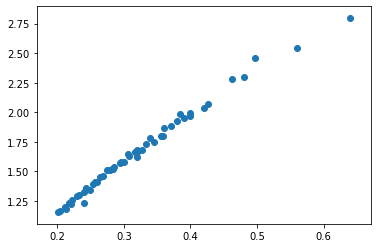

In [187]:
plt.scatter(x,y**(1/m_fk))

# functionally compute power law fits of given xy values


$$
w = M q^m = (B q)^m
$$

$\text{let } M_{FK}\equiv B_{FK}^{m_{FK}},\,\text{and let}\;M_{LR}\equiv B_{LR}^{m_{LR}}.$


<table>
  <tr>
    <td></td>
    <td>m</td>
    <td>M (Hz/cm$^{2(m-1)}$)</td>
  </tr>
  <tr>
    <td>Fenton-Karma</td>
    <td>-</td>
    <td>5.34+-0.26</td>
  </tr>
  <tr>
    <td>Luo-Rudy</td>
    <td>-</td>
    <td>16.74+-0.85</td>
  </tr>
</table>

In [128]:
# #compute w_lr and w_fk using a linear regression of a log-log plot
# yscale=10**3
# query=(fk.q>0.2)&(fk.q<1.)#fk.q<0.7#<0.2
# x=fk[query].q.values
# y=yscale*fk[query].w.values
# print_fit_power_law(x,y)
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
rmse=compute_power_rmse(x,y,m,B)
M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
print(f"m={m:.3f}+-{Delta_m:.3f}; B={B:.3f}+-{Delta_B:.3f}")
print(f"M=B**m={M:.2f}+-{Delta_M:.2f} Hz*cm^{{2(m-1)}}")
print(f"RMSE={rmse:.4f} Hz/cm^2")
print(f"R^2={Rsq:.3f}")

#load the other models and print/plot their power laws
data_folder=f"{nb_dir}/data/full_results/ncbc"
assert (os.path.exists(data_folder))
os.chdir(data_folder)
input_fn_lst=sorted([fn for fn in os.listdir() if fn.find('.csv')!=-1])
len(input_fn_lst)

def load_df_wj(fn):
    df=pd.read_csv(fn)
    df['L']=(df.index.values+1)/df.x.values
    df['A']=np.sqrt(df['L'])
    df['wl']=df.y/df.L
    df['wa']=df.y/df.A
    df['ql']=df.x
    df['qa']=df.x*df.L
    return df
for fn in input_fn_lst:
    df=load_df_wj(fn)
    print('\n'+fn)
    yscale=10**3
    query=(df.x>0.2)&(df.x<1.)&(df.y>0.)#fk.q<0.7#<0.2
    x=df[query].x.values
    y=yscale*df[query].y.values
    print_fit_power_law(x,y)

m=1.038+-0.035; B=1.999+-0.096
M=B**m=2.05+-0.16 Hz*cm^{2(m-1)}
RMSE=0.0519 Hz/cm^2
R^2=0.984


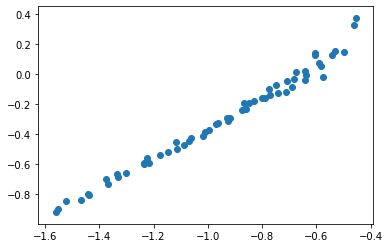

In [134]:
plt.scatter(X,Y)

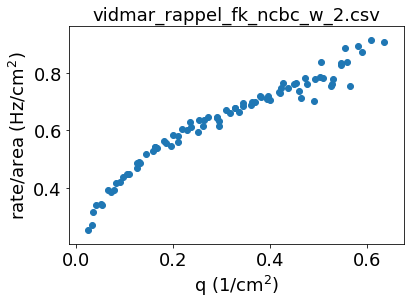

In [100]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
fontsize=18
fn=input_fn_lst[-2]
yscale=10**3
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
# x=df.qa.values
# y=yscale*df.wa.values*df.A.values
W=eval(fn[fn.find('_w_')+3:-4])
boo_lr=fn.find('_lr_')!=-1
plt.scatter(x, y,label=r"$W_{{{:+}}}$".format(W))
#     plt.errorbar(x, y, yerr=y*0.01, fmt='-o',label=r"W_{:+}".format(W))

# plt.plot(x, m_fk+0.*np.array(x), '--',c='gray',label='Fenton-Karma')
# plt.plot(x, m_lr+0.*np.array(x), '-',c='gray',label='Luo-Rudy')
# plt.scatter(Dtdt_lst,m_lst,marker='^')
# plt.xscale('log')
title=os.path.basename(fn)
# if boo_lr:
#     title='Luo-Rudy Model'
# else:
#     title='Fenton-Karma Model'
plt.title(title,fontsize=fontsize)
# plt.legend(fontsize=fontsize-4)

plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'rate/area (Hz/cm$^2$)',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0,3.5])
# plt.grid('on')
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
# print(f"considering {q_min}<q<{q_max}")

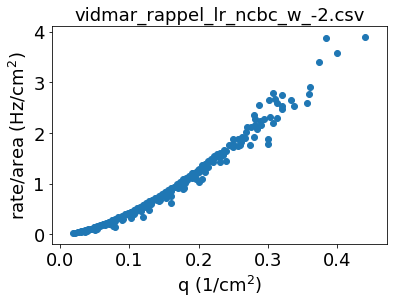

In [104]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
fontsize=18
fn=input_fn_lst[1]
yscale=10**3
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
# x=df.qa.values
# y=yscale*df.wa.values*df.A.values
W=eval(fn[fn.find('_w_')+3:-4])
boo_lr=fn.find('_lr_')!=-1
plt.scatter(x, y,label=r"$W_{{{:+}}}$".format(W))
#     plt.errorbar(x, y, yerr=y*0.01, fmt='-o',label=r"W_{:+}".format(W))

# plt.plot(x, m_fk+0.*np.array(x), '--',c='gray',label='Fenton-Karma')
# plt.plot(x, m_lr+0.*np.array(x), '-',c='gray',label='Luo-Rudy')
# plt.scatter(Dtdt_lst,m_lst,marker='^')
# plt.xscale('log')
title=os.path.basename(fn)
# if boo_lr:
#     title='Luo-Rudy Model'
# else:
#     title='Fenton-Karma Model'
plt.title(title,fontsize=fontsize)
# plt.legend(fontsize=fontsize-4)

plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'rate/area (Hz/cm$^2$)',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0,3.5])
# plt.grid('on')
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
# print(f"considering {q_min}<q<{q_max}")

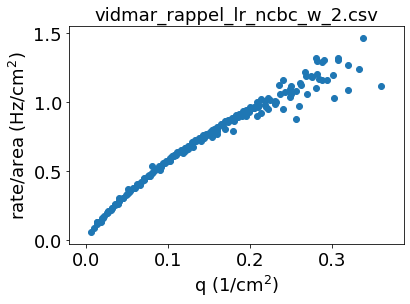

In [106]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
fontsize=18
fn=input_fn_lst[2]
yscale=10**3
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
# x=df.qa.values
# y=yscale*df.wa.values*df.A.values
W=eval(fn[fn.find('_w_')+3:-4])
boo_lr=fn.find('_lr_')!=-1
plt.scatter(x, y,label=r"$W_{{{:+}}}$".format(W))
#     plt.errorbar(x, y, yerr=y*0.01, fmt='-o',label=r"W_{:+}".format(W))

# plt.plot(x, m_fk+0.*np.array(x), '--',c='gray',label='Fenton-Karma')
# plt.plot(x, m_lr+0.*np.array(x), '-',c='gray',label='Luo-Rudy')
# plt.scatter(Dtdt_lst,m_lst,marker='^')
# plt.xscale('log')
title=os.path.basename(fn)
# if boo_lr:
#     title='Luo-Rudy Model'
# else:
#     title='Fenton-Karma Model'
plt.title(title,fontsize=fontsize)
# plt.legend(fontsize=fontsize-4)

plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'rate/area (Hz/cm$^2$)',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0,3.5])
# plt.grid('on')
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
# print(f"considering {q_min}<q<{q_max}")

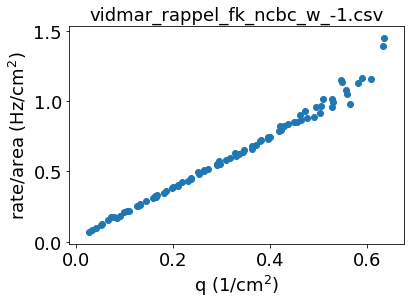

In [108]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
fontsize=18
fn=input_fn_lst[3]
yscale=10**3
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
# x=df.qa.values
# y=yscale*df.wa.values*df.A.values
W=eval(fn[fn.find('_w_')+3:-4])
boo_lr=fn.find('_lr_')!=-1
plt.scatter(x, y,label=r"$W_{{{:+}}}$".format(W))
title=os.path.basename(fn)
# if boo_lr:
#     title='Luo-Rudy Model'
# else:
#     title='Fenton-Karma Model'
plt.title(title,fontsize=fontsize)
# plt.legend(fontsize=fontsize-4)

plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'rate/area (Hz/cm$^2$)',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0,3.5])
# plt.grid('on')
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
# print(f"considering {q_min}<q<{q_max}")

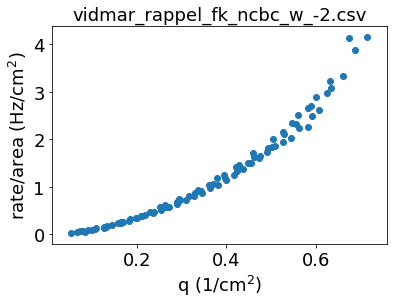

In [109]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
fontsize=18
fn=input_fn_lst[4]
yscale=10**3
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
# x=df.qa.values
# y=yscale*df.wa.values*df.A.values
W=eval(fn[fn.find('_w_')+3:-4])
boo_lr=fn.find('_lr_')!=-1
plt.scatter(x, y,label=r"$W_{{{:+}}}$".format(W))
title=os.path.basename(fn)
# if boo_lr:
#     title='Luo-Rudy Model'
# else:
#     title='Fenton-Karma Model'
plt.title(title,fontsize=fontsize)
# plt.legend(fontsize=fontsize-4)

plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'rate/area (Hz/cm$^2$)',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0,3.5])
# plt.grid('on')
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
# print(f"considering {q_min}<q<{q_max}")

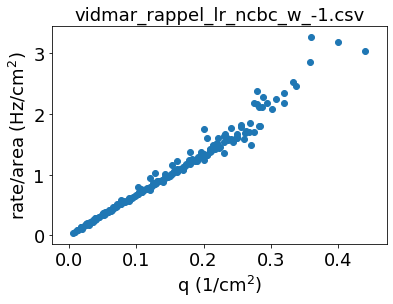

In [110]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
fontsize=18
fn=input_fn_lst[5]
yscale=10**3
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
# x=df.qa.values
# y=yscale*df.wa.values*df.A.values
W=eval(fn[fn.find('_w_')+3:-4])
boo_lr=fn.find('_lr_')!=-1
plt.scatter(x, y,label=r"$W_{{{:+}}}$".format(W))
title=os.path.basename(fn)
# if boo_lr:
#     title='Luo-Rudy Model'
# else:
#     title='Fenton-Karma Model'
plt.title(title,fontsize=fontsize)
# plt.legend(fontsize=fontsize-4)

plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'rate/area (Hz/cm$^2$)',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0,3.5])
# plt.grid('on')
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
# print(f"considering {q_min}<q<{q_max}")

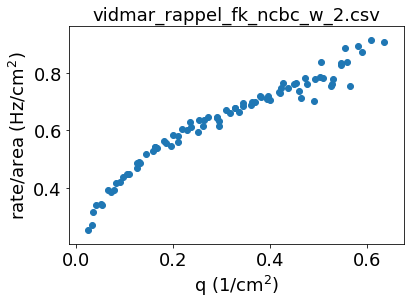

In [111]:
m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
fontsize=18
fn=input_fn_lst[6]
yscale=10**3
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
# x=df.qa.values
# y=yscale*df.wa.values*df.A.values
W=eval(fn[fn.find('_w_')+3:-4])
boo_lr=fn.find('_lr_')!=-1
plt.scatter(x, y,label=r"$W_{{{:+}}}$".format(W))
title=os.path.basename(fn)
# if boo_lr:
#     title='Luo-Rudy Model'
# else:
#     title='Fenton-Karma Model'
plt.title(title,fontsize=fontsize)
# plt.legend(fontsize=fontsize-4)

plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'rate/area (Hz/cm$^2$)',fontsize=fontsize)
# plt.xscale('log')
# plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0,3.5])
# plt.grid('on')
plt.show()
# print("considering 20<N<50 spiral tips")
# print("considering N<20 spiral tips")
# print(f"considering {q_min}<q<{q_max}")

# power law fits of full models
-- TODO: email MWC

In [103]:
# #compute w_lr and w_fk using a linear regression of a log-log plot
# yscale=10**3
# query=(fk.q>0.2)&(fk.q<1.)#fk.q<0.7#<0.2
# x=fk[query].q.values
# y=yscale*fk[query].w.values
# print_fit_power_law(x,y)
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
rmse=compute_power_rmse(x,y,m,B)
M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
print(f"m={m:.3f}+-{Delta_m:.3f}; B={B:.3f}+-{Delta_B:.3f}")
print(f"M=B**m={M:.2f}+-{Delta_M:.2f} Hz*cm^{{2(m-1)}}")
print(f"RMSE={rmse:.4f} Hz/cm^2")
print(f"R^2={Rsq:.3f}")

#load the other models and print/plot their power laws
data_folder=f"{nb_dir}/data/full_results/ncbc"
assert (os.path.exists(data_folder))
os.chdir(data_folder)
input_fn_lst=sorted([fn for fn in os.listdir() if fn.find('.csv')!=-1])
len(input_fn_lst)

def load_df_wj(fn):
    df=pd.read_csv(fn)
    df['L']=(df.index.values+1)/df.x.values
    df['A']=np.sqrt(df['L'])
    df['wl']=df.y/df.L
    df['wa']=df.y/df.A
    df['ql']=df.x
    df['qa']=df.x*df.L
    return df
for fn in input_fn_lst:
    df=load_df_wj(fn)
    print('\n'+fn)
    yscale=10**3
    query=(df.x>0.2)&(df.x<1.)&(df.y>0.)#fk.q<0.7#<0.2
    x=df[query].x.values
    y=yscale*df[query].y.values
    print_fit_power_law(x,y)

m=2.349+-0.050; B=3.971+-0.085
M=B**m=25.52+-3.27 Hz*cm^{2(m-1)}
RMSE=0.0070 Hz/cm^2
R^2=0.999

vidmar_rappel_fk_ncbc_w_-1.csv
m=1.038+-0.035; B=1.999+-0.096
M=B**m=2.05+-0.16 Hz*cm^{2(m-1)}
RMSE=0.0519 Hz/cm^2
R^2=0.984

vidmar_rappel_fk_ncbc_w_-2.csv
m=1.908+-0.044; B=2.879+-0.084
M=B**m=7.52+-0.82 Hz*cm^{2(m-1)}
RMSE=0.1544 Hz/cm^2
R^2=0.991

vidmar_rappel_fk_ncbc_w_1.csv
m=0.539+-0.080; B=0.538+-0.081
M=B**m=0.72+-0.03 Hz*cm^{2(m-1)}
RMSE=0.0325 Hz/cm^2
R^2=0.810

vidmar_rappel_fk_ncbc_w_2.csv
m=0.367+-0.032; B=1.125+-0.117
M=B**m=1.04+-0.05 Hz*cm^{2(m-1)}
RMSE=0.0335 Hz/cm^2
R^2=0.906

vidmar_rappel_lr_ncbc_w_-1.csv
m=1.216+-0.128; B=6.328+-0.657
M=B**m=9.43+-4.19 Hz*cm^{2(m-1)}
RMSE=0.1694 Hz/cm^2
R^2=0.871

vidmar_rappel_lr_ncbc_w_-2.csv
m=1.495+-0.105; B=5.814+-0.420
M=B**m=13.89+-4.80 Hz*cm^{2(m-1)}
RMSE=0.1773 Hz/cm^2
R^2=0.923

vidmar_rappel_lr_ncbc_w_1.csv
m=0.335+-0.521; B=0.222+-0.367
M=B**m=0.60+-nan Hz*cm^{2(m-1)}
RMSE=0.0601 Hz/cm^2
R^2=0.052

vidmar_rappel_lr_ncbc_w_2

/home/timothytyree/Documents/GitHub/bgmc/python/lib/measure/powerlaw.py:10: RuntimeWarning: invalid value encountered in double_scalars
  min_bound=(B-Delta_B)**(m-Delta_m)


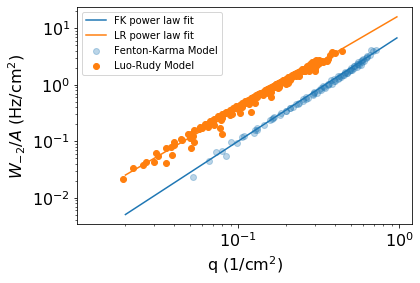

In [104]:
# m_fk=1.945#1.858;#+-0.027; B_fk=2.464+-0.030<br>
# m_lr=1.544#1.638;#+-0.017; B_fk=5.588+-0.067
fontsize=16
xv=np.arange(0.02,1.,.05)
yscale=10**3

#plot data for fk model
fn='vidmar_rappel_fk_ncbc_w_-2.csv'
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
plt.scatter(x, y,label='Fenton-Karma Model',alpha=0.3)
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
yv_fk=(B*xv)**m

#plot data for lr model
fn='vidmar_rappel_lr_ncbc_w_-2.csv'
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
plt.scatter(x, y,label='Luo-Rudy Model')
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
yv_lr=(B*xv)**m

#plot power law fits
plt.plot(xv,yv_fk,label='FK power law fit')
plt.plot(xv,yv_lr,label='LR power law fit')


# plt.title('Absorbing boundary conditions',fontsize=fontsize)
plt.legend(fontsize=fontsize-6)#,loc='lower right')
plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'$W_{{-2}}/A$ (Hz/cm$^2$)',fontsize=fontsize)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
# plt.legend(fontsize=fontsize-8)#,ncol=2)
# plt.xlim([10,50])
# plt.ylim([0,3.5])
plt.show()

In [105]:
M_lst=[]; Delta_M_lst=[]
m_lst=[]; Delta_m_lst=[]
cat_lst=[]
data_fk_fn='full_results/data_fig4_vidmar_fk_tt.csv'
data_lr_fn='full_results/data_fig4_vidmar_lr_tt.csv'



#load the other models and print/plot their power laws
data_folder=f"{nb_dir}/data/full_results/ncbc"
assert (os.path.exists(data_folder))
os.chdir(data_folder)
input_fn_lst=sorted([fn for fn in os.listdir() if fn.find('.csv')!=-1])
# len(input_fn_lst)
os.chdir(data_folder)
fn='vidmar_rappel_fk_ncbc_w_-2.csv'
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
rmse=compute_power_rmse(x,y,m,B)
M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
M_lst.append(M);Delta_M_lst.append(Delta_M);
m_lst.append(m);Delta_m_lst.append(Delta_m);
cat_lst.append('Fenton-Karma\n(NCBC)')

#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)
yscale=10**3
fn=os.path.basename(data_fk_fn)
fk=pd.read_csv(data_fk_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A'] #[mHz?]/cm^2
# query=(fk.q>0.2)&(fk.q<1.)#fk.q<0.7#<0.2
x=fk.q.values
y=yscale*fk.w.values
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
rmse=compute_power_rmse(x,y,m,B)
M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
M_lst.append(M);Delta_M_lst.append(Delta_M);
m_lst.append(m);Delta_m_lst.append(Delta_m);
cat_lst.append('Fenton-Karma\n(PBC)')

#load the other models and print/plot their power laws
data_folder=f"{nb_dir}/data/full_results/ncbc"
assert (os.path.exists(data_folder))
os.chdir(data_folder)
input_fn_lst=sorted([fn for fn in os.listdir() if fn.find('.csv')!=-1])
# len(input_fn_lst)
fn='vidmar_rappel_lr_ncbc_w_-2.csv'
df=load_df_wj(fn)#.sort_values('x')
x=df.x.values
y=yscale*df.y.values
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
rmse=compute_power_rmse(x,y,m,B)
M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
M_lst.append(M);Delta_M_lst.append(Delta_M);
m_lst.append(m);Delta_m_lst.append(Delta_m);
cat_lst.append('Luo-Rudy\n(NCBC)')



#load birth death rates from the full model
data_folder=f'{nb_dir}/data'
os.chdir(data_folder)
fn=os.path.basename(data_lr_fn)
fk=pd.read_csv(data_lr_fn)
fk['N']=fk['No2']*2
fk['q']=fk['N']/fk['A'] #number of tips per square centimeter
fk['w']=fk['rate']/fk['A'] #[mHz?]/cm^2
x=fk.q.values
y=yscale*fk.w.values
B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
rmse=compute_power_rmse(x,y,m,B)
M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)
M_lst.append(M);Delta_M_lst.append(Delta_M);
m_lst.append(m);Delta_m_lst.append(Delta_m);
cat_lst.append('Luo-Rudy\n(PBC)')

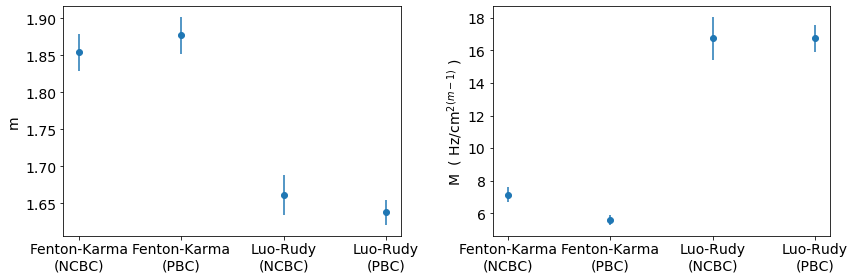

In [106]:
cat_lst


################
# Start Plotting
################
figsize=12,4
fontsize=14
fig,axs=plt.subplots(ncols=2,figsize=figsize)

################
# Plot FK/LR NCBC/PBC
################
ax=axs[0]
ax.errorbar(x=cat_lst, y=m_lst, yerr=Delta_m_lst, fmt='o')#,label=r"W_{:+}".format(W))
ax.set_ylabel(r'm',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)

ax=axs[1]
ax.errorbar(x=cat_lst, y=M_lst, yerr=Delta_M_lst, fmt='o')#,label=r"W_{:+}".format(W))
ax.set_ylabel(r'M  ( Hz/cm$^{{2(m-1)}}$ )',fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)
ax.tick_params(axis='both', which='minor', labelsize=0)

plt.tight_layout()
plt.show()

In [109]:
#print the values
for cat, m, Delta_m, M, Delta_M in zip ( cat_lst, m_lst, Delta_m_lst, M_lst, Delta_M_lst):
    print (cat, m, Delta_m, M, Delta_M)

Fenton-Karma
(NCBC) 1.854156794480594 0.02503190538288011 7.135532649256895 0.4548432215549294
Fenton-Karma
(PBC) 1.8772341309722325 0.02498750277237229 5.572315674840435 0.3053120355191732
Luo-Rudy
(NCBC) 1.6611400039209043 0.02740424198712116 16.75061667963681 1.3110747548319708
Luo-Rudy
(PBC) 1.6375562704001745 0.017190912126700632 16.73559858353835 0.8465090320196467


In [110]:
m_values=np.array([1.8772341309722325, 1.6375562704001745])
M_values=np.array([5.572315674840435,16.73559858353835])

In [117]:
import numpy as np
niter=250 #trials per worker
r_values=np.array([0.1,0.5,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.,2.5,5.,10.,20.])#cm
D_values=np.array([0.2,1.0,1.5,2.0,5.,10,20])#cm^2/s
A_values=np.array([20.25,25,39,50,56.25,100,156.25,189,250])[::-1]#cm^2
L_values=np.sqrt(A_values)#cm
# kappa_values=np.array([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,250,500])#1/s
# beta_values=np.array([0.01,0.05,0.01,0.1,0.5,1])#cm
Dt_values=np.array([1.])
reflect_values=np.array([0])
set_second_values=np.array([0])
m_values=np.array([1.8772341309722325, 1.6375562704001745])
M_values=np.array([5.572315674840435,16.73559858353835])
num_trials_per_setting=6

Dratio_values=np.array([1,10,100,1000])

def comp_M_tilde(m):
    '''non-quadratic trend is guessed to make bounds'''
    val_lst=[]
    val_lst.append(np.pi**(m-1)/m)
    val_lst.append(np.pi**(m-1)/2)
    val_lst.append(np.pi/2)
    val_lst.append((np.pi/2)**(m-1))
    mn=np.min(val_lst)
    mx=np.max(val_lst)
    return mn,mx

def comp_kappa(M,m,r):
    '''returns a min/max estimate for kappa using the emergent universal law'''
    mn,mx=comp_M_tilde(m)
    kappa_mn=r**(-2*(m-1))*M/mx
    kappa_mx=r**(-2*(m-1))*M/mn
    return kappa_mn,kappa_mx

#iterate over settings, scheduling the longest jobs first
count=0
for set_second in set_second_values:
    for r in r_values:
        for D in D_values:
            for L in L_values:
                for Dt in Dt_values:
                    for reflect in reflect_values:
                        for m,M in zip(m_values,M_values):
                            kappa_mn_mx=comp_kappa(M,m,r)
                            kappa_values=np.array(sorted(set([kappa_mn_mx[0],(kappa_mn_mx[0]+kappa_mn_mx[1])/2.,kappa_mn_mx[1]])))
                            for kappa in kappa_values:
                                for Dratio in Dratio_values:
                                    num_trials=0
                                    while num_trials<num_trials_per_setting:
                                        num_trials+=1
                                        count=count+1
#     									print(f"{r} {D} {L} {Dt} {niter} {reflect} {set_second} {temperature_energy} {energy_gap} {Dratio}")
print(count)


154224


# determining the slope at low densities versus reaction range
- TODO: if I change kappa, does the slope change, too?

In [ ]:
D=5.;kappa=500;Dt_over_dt=1.;L=L_values[-1]
query=(df.reflect==0)&(df.Dt_over_dt==Dt_over_dt)&(df.D==D)&(df.kappa==kappa)&(df.L==L)#(df.set_second==0)&
title=r"$\kappa$="+f"{kappa:.0f},D={D}"
# title=f"r={r:.1f},"+r"$\kappa$="+f"{kappa:.0f},D={D}"
dg=df[query].copy()
fontsize=16
r_lst=[]
m_lst=[]
Delta_m_lst=[]
q_min=.02;q_max=.2 #low density
q_min=0.2;q_max=.4 #high density
for r in [.1,1,2]:#r_values:#
    query2 = dg.r==r
    dg2=dg[query2].sort_values('q')
    x_values=dg2.q.values
    y_values=dg2.w.values
#     c_values=Dt_over_dt+0.*x_values

    plt.scatter(x_values,y_values,label=f'r={r:.1f} cm',alpha=0.5)#,s=4)#,c=c_values)
#     boo=(x_values>40)&(x_values<60)
#     boo=(x_values<20)
    boo=(x_values>q_min)&(x_values<q_max)
    x=x_values[boo]#[:10]#[300-11:]
    y=y_values[boo]#[:10]#[300-11:]
    dict_out=compute_95CI_ols(np.log(x),np.log(y))
    m=dict_out['m']
    Delta_m=dict_out['Delta_m']*2
    r_lst.append(r)
    m_lst.append(m)
    Delta_m_lst.append(Delta_m)
    
    print(f'for r={r:.1f}, m={m:.8f}.')
plt.title(title,fontsize=fontsize)
plt.xlabel(r'q (1/cm$^2$)',fontsize=fontsize)
plt.ylabel(r'w (Hz/cm$^2$)',fontsize=fontsize)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=fontsize)
plt.tick_params(axis='both', which='minor', labelsize=0)
plt.legend(fontsize=fontsize-8,ncol=2)
plt.xlim([.02,100])
plt.ylim([0.01,100000])
plt.show()

In [22]:
def comp_kappa(M,m,r):
    '''returns a min/max estimate for kappa using the emergent universal law'''
    def comp_M_tilde(m):
        '''non-quadratic trend is guessed to make bounds'''
        val_lst=[]
        val_lst.append(np.pi**(m-1)/m)
        val_lst.append(np.pi**(m-1)/2)
        val_lst.append(np.pi/2)
        val_lst.append((np.pi/2)**(m-1))
        mn=np.min(val_lst)
        mx=np.max(val_lst)
        return mn,mx
    mn,mx=comp_M_tilde(m)
    kappa_mn=r**(-2*(m-1))*M/mx
    kappa_mx=r**(-2*(m-1))*M/mn
    return kappa_mn,kappa_mx

In [65]:
comp_kappa(15,1,10)

(9.549296585513721, 30.0)

In [66]:
comp_kappa(15,2,10)

(0.0954929658551372, 0.0954929658551372)

In [31]:
comp_kappa(13,1.8,2)

(2.730080683828754, 3.432459777466321)

In [16]:
comp_kappa(1,3,1)

(0.20264236728467555, 0.6366197723675814)

In [99]:
#plot large r and measure its slope
# D=2.;r=10;kappa=5;
D=2.;r=0.5;kappa=50;
query=(df.r==r)&(df.D==D)&(df.kappa==kappa)
Llst=sorted(set(df[query].L.values))
L=Llst[1]
query&=df.L==L
dff=df[query].copy().drop(columns=['r','D','L','kappa'])
if dff.size>0:
    #compute x,y values
    A=L**2
#             dfd=dff.groupby('N').CollRate.mean()
#             dfd.drop('set_second',inplace=True)
#             x_values=dfd.values
#             y_values=dfd.index.values
    dfd=dff.mean()
    x_values=np.array([eval(iv) for iv in dfd.index.values])/A
    y_values=dfd.values.copy()**-1/A
    

else:
    print('caution: no values left in query')

q_min=0.2
q_max=0.3
boo=(x_values>q_min)&(x_values<q_max)
x=x_values[boo];y=y_values[boo]
print(f'when r={r:.1f},')
print_fit_power_law(x,y)
# B,Delta_B,m,Delta_m,Rsq=fit_power_law(x,y)
# rmse=compute_power_rmse(x,y,m,B)
# M, Delta_M= comp_power_scale(B,Delta_B,m,Delta_m)

when r=0.5,
m=2.349+-0.050; B=3.971+-0.085
M=B**m=25.52+-3.27 Hz*cm^{2(m-1)}
RMSE=0.0070 Hz/cm^2
R^2=0.999


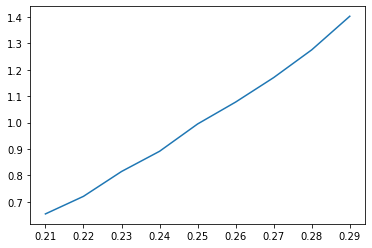

In [100]:
plt.plot(x,y)
plt.show()

__Result__
- slopes aren't matching... for large r, I'm still getting large slopes
- 

In [ ]:
#TODO: plot variable r with small kappa fixed

In [102]:
250*1.**2*np.pi/2

392.6990816987241

In [120]:
import numpy as np
niter=250 #trials per worker
r_values=np.array([0.1,0.5,1.,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2.,2.5,5.,10.,20.])#cm
D_values=np.array([0.2,1.0,1.5,2.0,5.,10,20])#cm^2/s
A_values=np.array([20.25,25,39,50,56.25,100,156.25,189,250])[::-1]#cm^2
L_values=np.sqrt(A_values)#cm
# kappa_values=np.array([5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100,250,500])#1/s
# beta_values=np.array([0.01,0.05,0.01,0.1,0.5,1])#cm
Dt_values=np.array([1.])
reflect_values=np.array([0])
set_second_values=np.array([0])
m_values=np.array([1.8772341309722325, 1.6375562704001745])
M_values=np.array([5.572315674840435,16.73559858353835])
num_trials_per_setting=6

Dratio_values=np.array([1,10,100,1000])
energy_gap_values=np.array(sorted([0.,-10,10,0.5,1,2,-1]))
temperature_energy_values=np.array([1.])

def comp_M_tilde(m):
    '''non-quadratic trend is guessed to make bounds'''
    val_lst=[]
    val_lst.append(np.pi**(m-1)/m)
    val_lst.append(np.pi**(m-1)/2)
    val_lst.append(np.pi/2)
    val_lst.append((np.pi/2)**(m-1))
    mn=np.min(val_lst)
    mx=np.max(val_lst)
    return mn,mx

def comp_kappa(M,m,r):
    '''returns a min/max estimate for kappa using the emergent universal law'''
    mn,mx=comp_M_tilde(m)
    kappa_mn=r**(-2*(m-1))*M/mx
    kappa_mx=r**(-2*(m-1))*M/mn
    return kappa_mn,kappa_mx

#iterate over settings, scheduling the longest jobs first
count=0
for set_second in set_second_values:
    for r in r_values:
        for D in D_values:
            for L in L_values:
                for Dt in Dt_values:
                    for reflect in reflect_values:
                        for m,M in zip(m_values,M_values):
                            kappa_mn_mx=comp_kappa(M,m,r)
                            kappa_values=np.array(sorted(set([kappa_mn_mx[0],(kappa_mn_mx[0]+kappa_mn_mx[1])/2.,kappa_mn_mx[1]])))
                            for kappa in kappa_values:
                                for Dratio in Dratio_values:
                                    for temperature_energy in temperature_energy_values:
                                        for energy_gap in energy_gap_values:
                                            num_trials=0
                                            while num_trials<num_trials_per_setting:
                                                num_trials+=1
                                                count=count+1
#                                                 print(f"{r} {D} {L} {Dt} {niter} {reflect} {set_second} {temperature_energy} {energy_gap} {Dratio}")
print(count)

1079568
